# Transformer NN

******************

**1. Task implementation**

Loading all the required libraries and support

In [29]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import time
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D


Loading the dataset and it;s content

In [30]:
# Load the dataset

df = pd.read_csv('IBM_2006-01-01_to_2018-01-01.csv')
df.head()


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
1,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
3,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
4,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [31]:
df= df[['Date','Close']]
df.head()


,Date,Close
0,2006-01-03,82.06
1,2006-01-04,81.95
2,2006-01-05,82.50
3,2006-01-06,84.95
4,2006-01-09,83.73


In [32]:
df.describe()

,Close
count,3020.000000
mean,145.617278
std,37.529387
min,71.740000
25%,116.525000
50%,149.315000
75%,178.685000
max,215.800000


In [33]:
df.rename(columns={'Date': 'date', 'Close': 'close'}, inplace=True)
df.head()

,date,close
0,2006-01-03,82.06
1,2006-01-04,81.95
2,2006-01-05,82.50
3,2006-01-06,84.95
4,2006-01-09,83.73


In [34]:
# Here we are, Setting date as the index
df['date'] = pd.to_datetime(df['date'])
df = df.set_index(['date'])
df.head()

,close
date,
2006-01-03,82.06
2006-01-04,81.95
2006-01-05,82.50
2006-01-06,84.95
2006-01-09,83.73


*Now, we will visualize the closing price to see how data is captured*

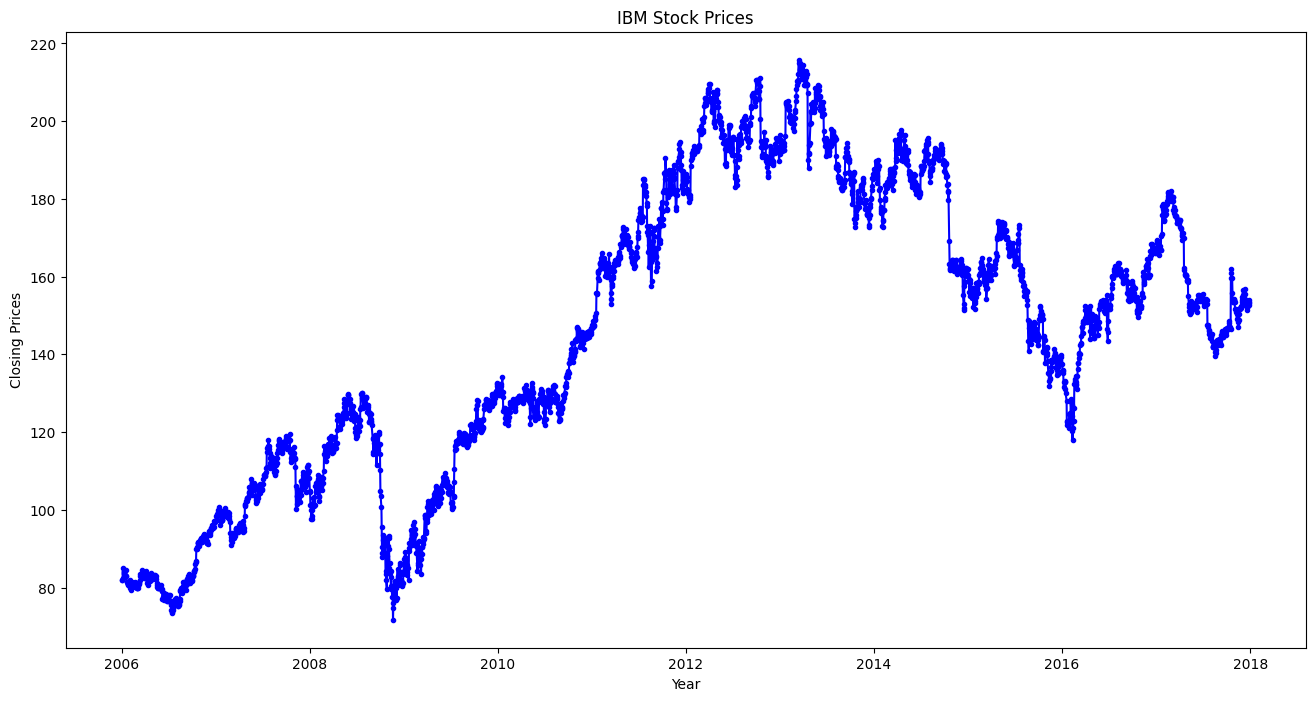

In [35]:
# Visualizing the time series
plt.figure(figsize=(16,8))
plt.xlabel("Year")
plt.ylabel("Closing Prices")
plt.title('IBM Stock Prices')
plt.plot(df.index, df.close, color = 'b', marker='.')

So, we preprocess of the dataset and
 we will split the dataset for test and train

In [38]:
# Now, here we Normalize the 'Close' prices
scaler = MinMaxScaler(feature_range=(0, 1))
df['close'] = scaler.fit_transform(df['close'].values.reshape(-1,1))

# Split the data into train and test
df_train = df.loc['2006-01-01':'2014-12-29']
df_test = df.loc['2015-01-01' : '2017-12-29']
print(df_train)
print(df_test)

# Function to create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), 0])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

# Create sequences from training and testing data
window_size = 50
X_train, y_train = create_sequences(df_train[['close']].values, window_size)
X_test, y_test = create_sequences(df_test[['close']].values, window_size)

               close
date                
2006-01-03  0.071637
2006-01-04  0.070873
2006-01-05  0.074691
2006-01-06  0.091698
2006-01-09  0.083229
...              ...
2014-12-22  0.622657
2014-12-23  0.628210
2014-12-24  0.625295
2014-12-26  0.628905
2014-12-29  0.616202

[2263 rows x 1 columns]
               close
date                
2015-01-02  0.626961
2015-01-05  0.609260
2015-01-06  0.585381
2015-01-07  0.578301
2015-01-08  0.601694
...              ...
2017-12-22  0.560600
2017-12-26  0.562890
2017-12-27  0.564973
2017-12-28  0.571290
2017-12-29  0.566986

[755 rows x 1 columns]


**Implementation of the Transformer Model**

In [39]:

def build_transformer_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    # Transformer Encoder
    for _ in range(2):  # Number of layers
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        x2 = tf.keras.layers.MultiHeadAttention(
            num_heads=2, key_dim=2, dropout=0.1
        )(x1, x1)
        x = tf.keras.layers.Add()([x, x2])
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        x3 = tf.keras.layers.Dense(64, activation='relu')(x3)
        x = tf.keras.layers.Add()([x, x3])

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (window_size, 1)
model = build_transformer_model(input_shape)
model.compile(optimizer='adam', loss='mean_squared_error')

So, we are now training the model

In [40]:
# Ensure data is reshaped for the Transformer model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the Transformer model
history = model.fit(
    X_train, y_train,
    epochs=10,  # Number of epochs can be adjusted
    batch_size=32,  # Batch size can be tuned
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/10
70/70 [==============================] - 4s 19ms/step - loss: 1.0904 - val_loss: 0.0305
Epoch 2/10
70/70 [==============================] - 1s 15ms/step - loss: 0.1735 - val_loss: 0.0117
Epoch 3/10
70/70 [==============================] - 1s 16ms/step - loss: 0.0257 - val_loss: 0.0028
Epoch 4/10
70/70 [==============================] - 2s 23ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 5/10
70/70 [==============================] - 1s 20ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 6/10
70/70 [==============================] - 1s 15ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 7/10
70/70 [==============================] - 1s 15ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 8/10
70/70 [==============================] - 1s 17ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 9/10
70/70 [==============================] - 2s 28ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 10/10
70/70 [==============================] - 2s 29ms/step - loss: 0.0024 - val_loss: 0.0029


** 2. Model comparison with LSTM: use visualization to report results (performance, time)**

**Below is LSTM Model Implementation previee**

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# LSTM Model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build and compile the LSTM model
lstm_model = build_lstm_model((window_size, 1))

# Train the LSTM model
lstm_history = lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/10
70/70 [==============================] - 6s 43ms/step - loss: 0.0168 - val_loss: 0.0010
Epoch 2/10
70/70 [==============================] - 2s 31ms/step - loss: 8.1810e-04 - val_loss: 7.2031e-04
Epoch 3/10
70/70 [==============================] - 2s 31ms/step - loss: 8.1034e-04 - val_loss: 6.8677e-04
Epoch 4/10
70/70 [==============================] - 2s 31ms/step - loss: 7.7819e-04 - val_loss: 7.0638e-04
Epoch 5/10
70/70 [==============================] - 3s 37ms/step - loss: 7.6159e-04 - val_loss: 6.8911e-04
Epoch 6/10
70/70 [==============================] - 3s 37ms/step - loss: 7.6540e-04 - val_loss: 9.3340e-04
Epoch 7/10
70/70 [==============================] - 2s 32ms/step - loss: 7.3454e-04 - val_loss: 6.6537e-04
Epoch 8/10
70/70 [==============================] - 2s 32ms/step - loss: 7.2501e-04 - val_loss: 6.6477e-04
Epoch 9/10
70/70 [==============================] - 3s 41ms/step - loss: 7.0153e-04 - val_loss: 5.4219e-04
Epoch 10/10
70/70 [==========================

**Now the part for Performance and Training Time Comparison**


---




We will evaluate both model here using MSE on the test dataset of the yahoo then we will compare MSE to find which model is good accuracy for prediction

1. Performance Compare

In [42]:
# Evaluate Transformer model
transformer_mse = model.evaluate(X_test, y_test, verbose=0)

# Evaluate LSTM model
lstm_mse = lstm_model.evaluate(X_test, y_test, verbose=0)

print(f"Transformer MSE: {transformer_mse}")
print(f"LSTM MSE: {lstm_mse}")

Transformer MSE: 0.0028729781042784452
LSTM MSE: 0.0005154127138666809


2. Training Time Comprision

Here i compare training times to assess computational efficiency.

In [43]:

# Training time for Transformer model
start_time = time.time()
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)
transformer_training_time = time.time() - start_time

# Training time for LSTM model
start_time = time.time()
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)
lstm_training_time = time.time() - start_time

print(f"Transformer Training Time: {transformer_training_time} seconds")
print(f"LSTM Training Time: {lstm_training_time} seconds")

Transformer Training Time: 20.514849185943604 seconds
LSTM Training Time: 40.98881959915161 seconds


*Visualizing the above comparision of the model performance and Training Time. *

a. Model Performance plot

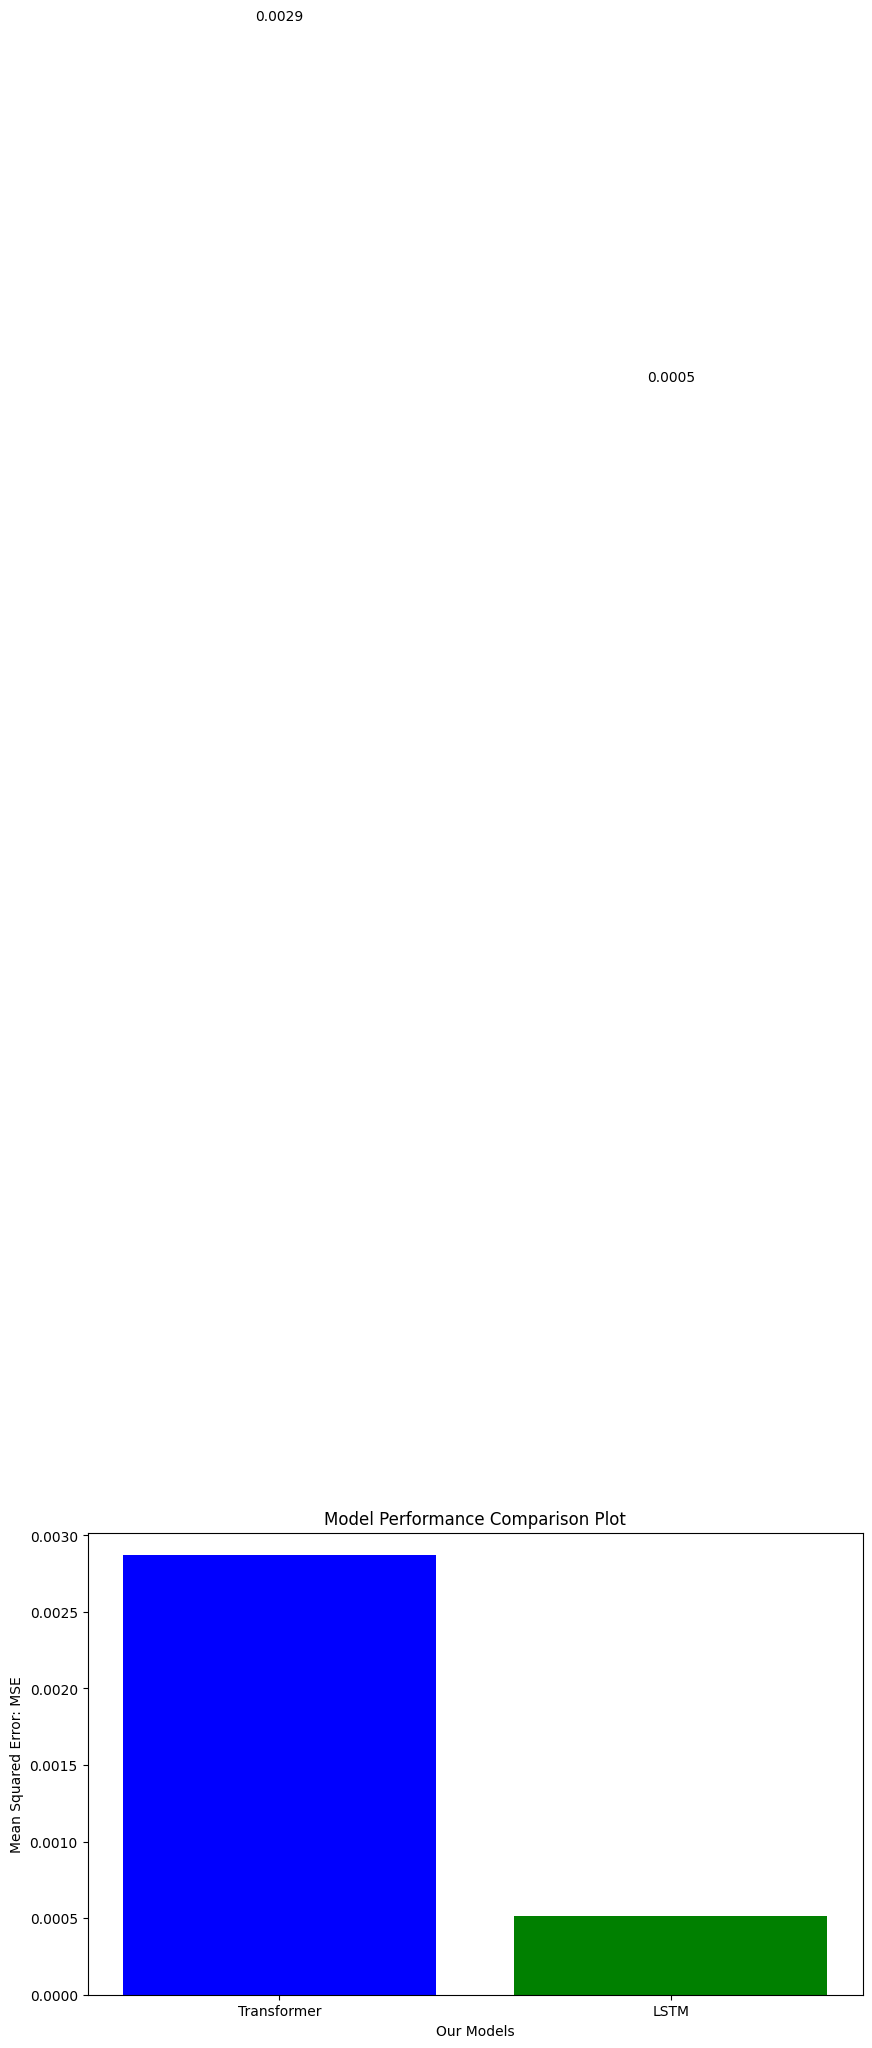

In [44]:
# MSE comparison
mse_values = [transformer_mse, lstm_mse]
model_names = ['Transformer', 'LSTM']

plt.figure(figsize=(10, 6))
plt.bar(model_names, mse_values, color=['blue', 'green'])
plt.title('Model Performance Comparison Plot')
plt.ylabel('Mean Squared Error: MSE')
plt.xlabel('Our Models')
for i, v in enumerate(mse_values):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom')
plt.show()

b. Training Time Plot

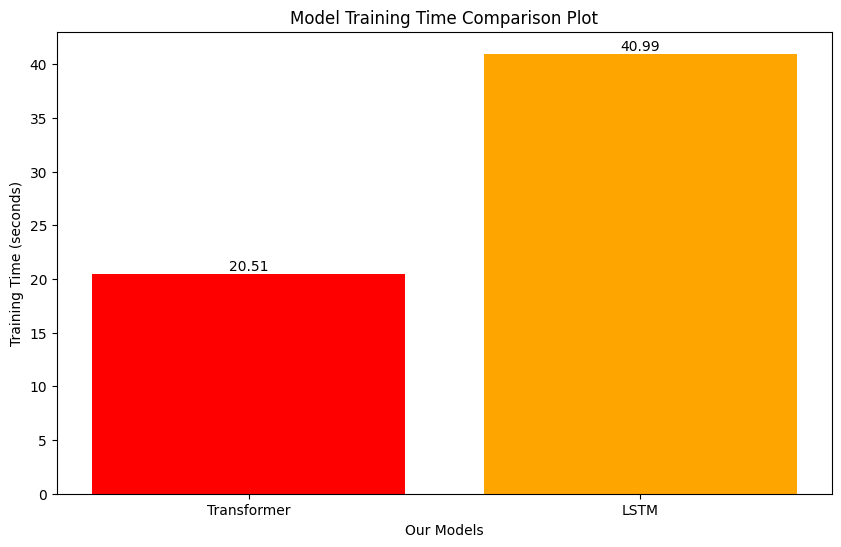

In [45]:
# Training time comparison
training_times = [transformer_training_time, lstm_training_time]

plt.figure(figsize=(10, 6))
plt.bar(model_names, training_times, color=['red', 'orange'])
plt.title('Model Training Time Comparison Plot')
plt.ylabel('Training Time (seconds)')
plt.xlabel('Our Models')
for i, v in enumerate(training_times):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')
plt.show()


# Prediction Part

*********************

**Now making Prediction and Plotting for both Model: LSTM and Transformer**

23/23 [==============================] - 1s 8ms/step


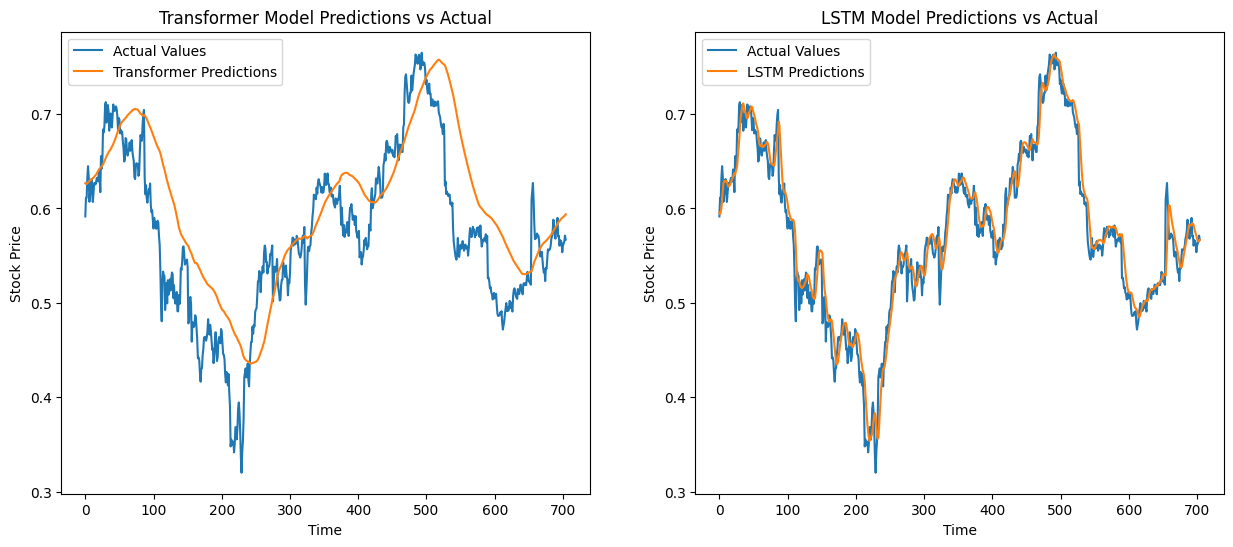

In [46]:
# Make predictions
transformer_predictions = model.predict(X_test)
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform the predictions and actual values to their original scale
transformer_predictions = scaler.inverse_transform(transformer_predictions)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting
plt.figure(figsize=(15, 6))

# Plot for Transformer predictions
plt.subplot(1, 2, 1)
plt.plot(y_test_original, label='Actual Values')
plt.plot(transformer_predictions, label='Transformer Predictions')
plt.title('Transformer Model Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

# Plot for LSTM predictions
plt.subplot(1, 2, 2)
plt.plot(y_test_original, label='Actual Values')
plt.plot(lstm_predictions, label='LSTM Predictions')
plt.title('LSTM Model Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

plt.show()


**4. Hyperparameter analysis (four hyperparameters)**

We will take 4 hyper paramaters and they are as belows:

1. Number of layers
2. Number of units in LSTM/Number of heads in Transformer
3. Learning rate
4. Batch size

**Hyperparameter Analysis for Transformer**



Step 1: We will define the Transformer Model with Adjustable Hyperparameters

In [49]:
def build_transformer_model(num_heads, num_layers, d_model, lr):
    inputs = Input(shape=(window_size, 1))

    x = Dense(d_model)(inputs)  # Projecting input to a higher dimension

    for _ in range(num_layers):
        # Multi-Head Attention
        attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        x = LayerNormalization(epsilon=1e-6)(x + attention_output)

        # Feed Forward Network
        ffn_output = Dense(d_model, activation="relu")(x)
        x = LayerNormalization(epsilon=1e-6)(x + ffn_output)

    x = GlobalAveragePooling1D()(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
    return model


Now,

Step 2: We are Performing the Hyperparameter Analysis here,

as we can see below, we are varying one hyperparamater at a time for simplicity.

In [50]:
# Hyperparameter options
heads_options = [2, 4, 6]
layers_options = [1, 2, 3]
learning_rate_options = [0.001, 0.01, 0.1]
batch_size_options = [32, 64, 128]

# Storage for MSE values
heads_mse = []
layers_mse = []
lr_mse = []
batch_size_mse = []

# Varying number of attention heads
for heads in heads_options:
    model = build_transformer_model(num_heads=heads, num_layers=2, d_model=128, lr=0.001)
    model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
    mse = model.evaluate(X_test, y_test, verbose=0)
    heads_mse.append(mse)
    print(f"Heads: {heads}, Test MSE: {mse}")

# Varying number of layers
for layers in layers_options:
    model = build_transformer_model(num_heads=2, num_layers=layers, d_model=128, lr=0.001)
    model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
    mse = model.evaluate(X_test, y_test, verbose=0)
    layers_mse.append(mse)
    print(f"layers: {layers}, Test MSE: {mse}")

# Varying learning rate
for lr in learning_rate_options:
    model = build_transformer_model(num_heads=2, num_layers=2, d_model=128, lr=lr)
    model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
    mse = model.evaluate(X_test, y_test, verbose=0)
    lr_mse.append(mse)
    print(f"lr: {lr}, Test MSE: {mse}")

# Varying batch size
for batch_size in batch_size_options:
    model = build_transformer_model(num_heads=2, num_layers=2, d_model=128, lr=0.001)
    model.fit(X_train, y_train, epochs=5, batch_size=batch_size, verbose=0)
    mse = model.evaluate(X_test, y_test, verbose=0)
    batch_size_mse.append(mse)
    print(f"Batch Size: {batch_size}, Test MSE: {mse}")

Heads: 2, Test MSE: 0.0044378191232681274
Heads: 4, Test MSE: 0.006846186239272356
Heads: 6, Test MSE: 0.016549721360206604
layers: 1, Test MSE: 0.003814225783571601
layers: 2, Test MSE: 0.005033560562878847
layers: 3, Test MSE: 0.0038123279809951782
lr: 0.001, Test MSE: 0.005756436847150326
lr: 0.01, Test MSE: 0.006606448441743851
lr: 0.1, Test MSE: 0.12829868495464325
Batch Size: 32, Test MSE: 0.0070625608786940575
Batch Size: 64, Test MSE: 0.00545464688912034
Batch Size: 128, Test MSE: 0.005487364716827869


Step 3: Plotting for Transformer Model for Hyperparamater analysis

I will compare the performance of this model under different settings.

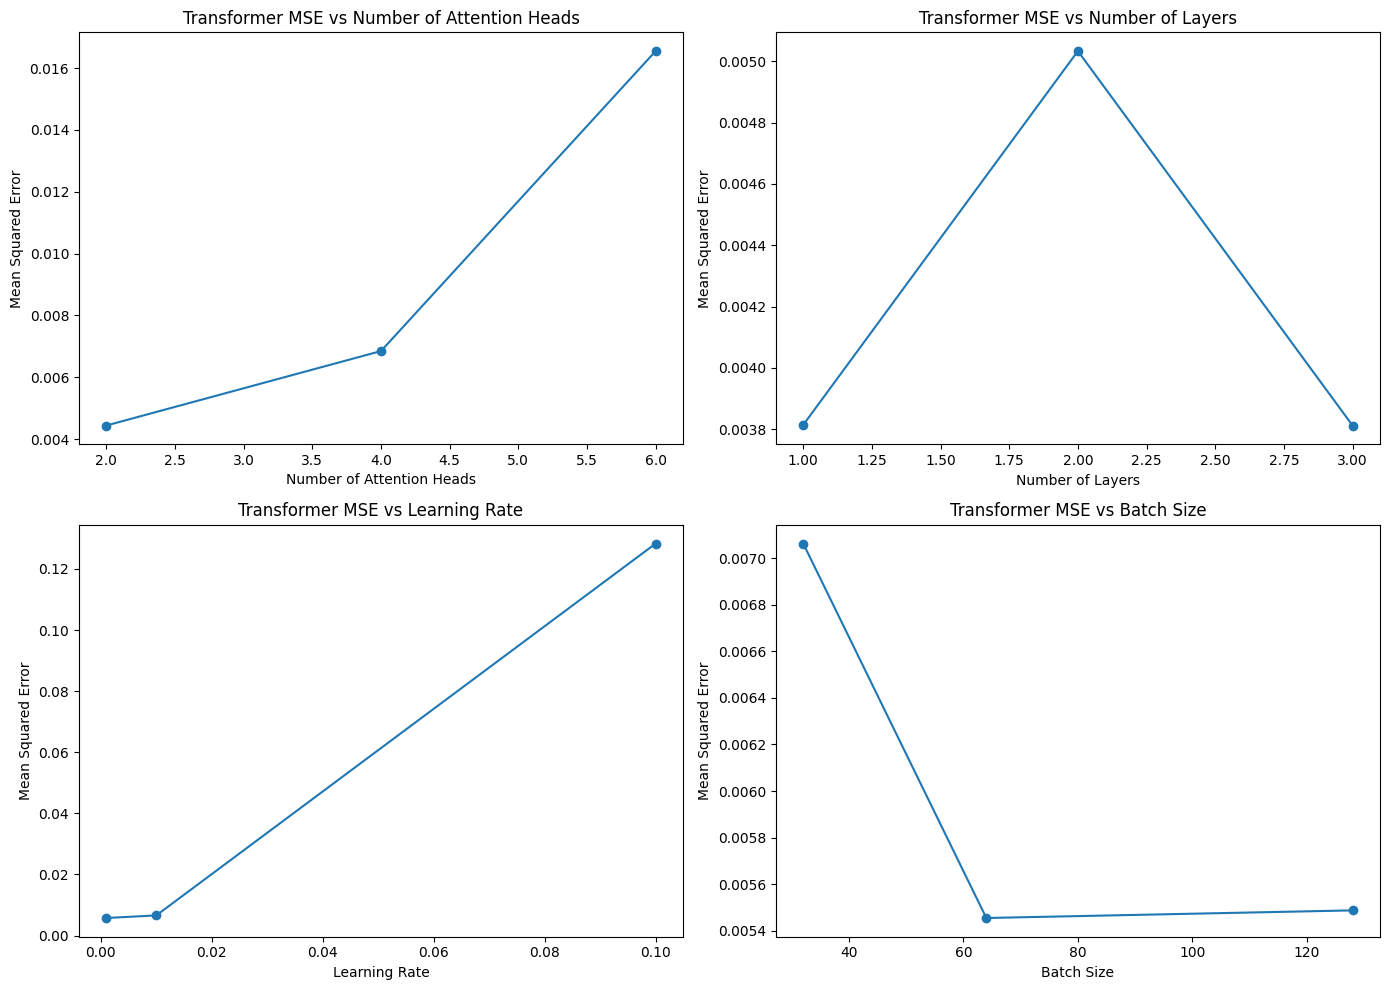

In [52]:
# Hyperparameter options used in the analysis
heads_options = [2, 4, 6]
layers_options = [1, 2, 3]
learning_rate_options = [0.001, 0.01, 0.1]
batch_size_options = [32, 64, 128]

# MSE values for the number of attention heads
heads_mse = [0.0044378191232681274, 0.006846186239272356, 0.016549721360206604]

# MSE values for the number of layers
layers_mse = [0.003814225783571601, 0.005033560562878847, 0.0038123279809951782]

# MSE values for different learning rates
lr_mse = [0.005756436847150326, 0.006606448441743851, 0.12829868495464325]

# MSE values for different batch sizes
batch_size_mse = [0.0070625608786940575,  0.00545464688912034, 0.005487364716827869]


# Plotting
plt.figure(figsize=(14, 10))

# Plot for Number of Attention Heads
plt.subplot(2, 2, 1)
plt.plot(heads_options, heads_mse, marker='o')
plt.title('Transformer MSE vs Number of Attention Heads')
plt.xlabel('Number of Attention Heads')
plt.ylabel('Mean Squared Error')

# Plot for Number of Layers
plt.subplot(2, 2, 2)
plt.plot(layers_options, layers_mse, marker='o')
plt.title('Transformer MSE vs Number of Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Mean Squared Error')

# Plot for Learning Rate
plt.subplot(2, 2, 3)
plt.plot(learning_rate_options, lr_mse, marker='o')
plt.title('Transformer MSE vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Squared Error')

# Plot for Batch Size
plt.subplot(2, 2, 4)
plt.plot(batch_size_options, batch_size_mse, marker='o')
plt.title('Transformer MSE vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Mean Squared Error')

plt.tight_layout()
plt.show()

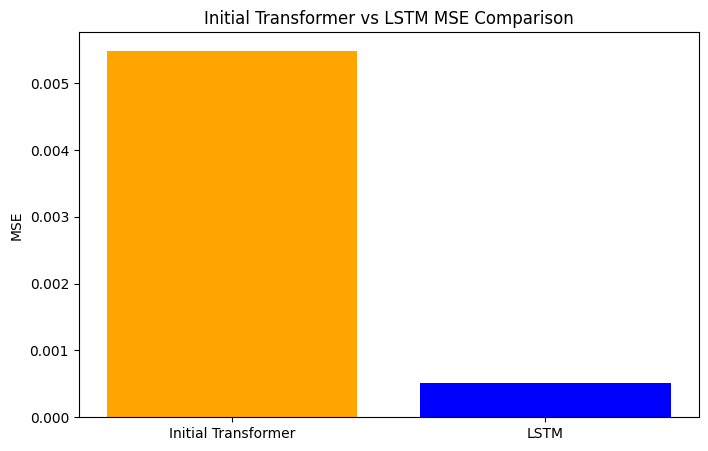

In [54]:
# Initial Transformer MSE
initial_transformer_mse = 0.005487364716827869

# LSTM MSE
lstm_mse = 0.0005154127138666809

# Plotting the comparison
plt.figure(figsize=(8, 5))
plt.bar(['Initial Transformer', 'LSTM'], [initial_transformer_mse, lstm_mse], color=['orange', 'blue'])
plt.ylabel('MSE')
plt.title('Initial Transformer vs LSTM MSE Comparison')
plt.show()


Now i will do the hyperparameter tuning to obtain the optimized model. then i will Compare the performances of the initial and tuned models.


this is to see the effects of before and after tuning performance on model for the prediction.